In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines: Metrics visualization and run comparison using the KFP SDK

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/pipelines/metrics_viz_run_compare_kfp.ipynb">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview

This notebook shows how to use [the Kubeflow Pipelines (KFP) SDK](https://www.kubeflow.org/docs/components/pipelines/) to build [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) that generate model metrics and metrics visualizations, and comparing pipeline runs.

### Dataset

The dataset used for this tutorial is the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the origin of a wine.

### Dataset

The dataset used for this tutorial is the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) from [Scikit-learn builtin datasets](https://scikit-learn.org/stable/datasets.html).

The dataset predicts the type of Iris flower species from a class of three species: setosa, virginica, or versicolor.

### Objective

The steps performed include:

- Generate ROC curve and confusion matrix visualizations for classification results
- Write metrics
- Compare metrics across pipeline runs

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

If you are using Colab or Google Cloud Notebook, your environment already meets all the requirements to run this notebook. You can skip this step.

Otherwise, make sure your environment meets this notebook's requirements. You need the following:

- The Cloud Storage SDK
- Git
- Python 3
- virtualenv
- Jupyter notebook running in a virtual environment with Python 3

The Cloud Storage guide to [Setting up a Python development environment](https://cloud.google.com/python/setup) and the [Jupyter installation guide](https://jupyter.org/install) provide detailed instructions for meeting these requirements. The following steps provide a condensed set of instructions:

1. [Install and initialize the SDK](https://cloud.google.com/sdk/docs/).

2. [Install Python 3](https://cloud.google.com/python/setup#installing_python).

3. [Install virtualenv](Ihttps://cloud.google.com/python/setup#installing_and_using_virtualenv) and create a virtual environment that uses Python 3.

4. Activate that environment and run `pip3 install Jupyter` in a terminal shell to install Jupyter.

5. Run `jupyter notebook` on the command line in a terminal shell to launch Jupyter.

6. Open this notebook in the Jupyter Notebook Dashboard.


## Installation

Install the latest version of Vertex AI SDK for Python.

In [ ]:
import os

# Google Cloud Notebook
if os.path.exists("/opt/deeplearning/metadata/env_version"):
    USER_FLAG = "--user"
else:
    USER_FLAG = ""
USER_FLAG = "--user"
! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG

Install the latest GA version of *google-cloud-storage* library as well.

In [ ]:
! pip3 install -U google-cloud-storage $USER_FLAG

Install the latest GA version of *KFP SDK* library as well.

In [ ]:
! pip3 install $USER_FLAG kfp --upgrade

In [ ]:
if os.getenv("IS_TESTING"):
    ! pip3 install --upgrade matplotlib $USER_FLAG

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [23]:
! python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

KFP SDK version: 1.8.12


## Before you begin

### GPU runtime

This tutorial does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)

4. [The Google Cloud SDK](https://cloud.google.com/sdk) is already installed in Google Cloud Notebook.

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$`.

In [52]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [53]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: sunny-avocado


In [54]:
! gcloud --quiet config set project $PROJECT_ID

Updated property [core/project].


In [55]:
!gcloud config list

[core]
account = 922446535713-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = sunny-avocado

Your active configuration is: [default]


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations)

In [56]:
REGION = "us-central1"  # @param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [57]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebook**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [58]:
# # If you are running this notebook in Colab, run this cell and follow the
# # instructions to authenticate your GCP account. This provides access to your
# # Cloud Storage bucket and lets you submit training jobs and prediction
# # requests.

# import os
# import sys

# # If on Google Cloud Notebook, then don't execute this code
# if not os.path.exists("/opt/deeplearning/metadata/env_version"):
#     if "google.colab" in sys.modules:
#         from google.colab import auth as google_auth

#         google_auth.authenticate_user()

#     # If you are running this notebook locally, replace the string below with the
#     # path to your service account key and run this cell to authenticate your GCP
#     # account.
#     elif not os.getenv("IS_TESTING"):
#         %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex AI SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [59]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}

In [60]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [63]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://sunny-avocadoaip-20220603154057/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [64]:
! gsutil ls -al $BUCKET_NAME

#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [65]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [66]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your GCP project id from gcloud
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace('*', '').strip()
    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 922446535713-compute@developer.gserviceaccount.com


#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [67]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_NAME

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_NAME

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [68]:
import google.cloud.aiplatform as aip

#### Vertex AI Pipelines constants

Setup up the following constants for Vertex AI Pipelines:

In [69]:
PIPELINE_ROOT = "{}/pipeline_root/iris".format(BUCKET_NAME)
PIPELINE_ROOT

'gs://sunny-avocadoaip-20220603154057/pipeline_root/iris'

Additional imports.

In [70]:
from kfp.v2 import dsl
from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, component

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

### Define pipeline components using scikit-learn

In this section, you define some Python function-based components that use scikit-learn to train some classifiers and produce evaluations that can be visualized.

Note the use of the `@component()` decorator in the definitions below. You can optionally set a list of packages for the component to install; the base image to use (the default is a Python 3.7 image); and the name of a component YAML file to generate, so that the component definition can be shared and reused.

#### Define wine_classification component

The first component shows how to visualize an *ROC curve*.
Note that the function definition includes an output called `wmetrics`, of type `Output[ClassificationMetrics]`. You can visualize the metrics in the Pipelines user interface in the Cloud Console.

To do this, this example uses the artifact's `log_roc_curve()` method. This method takes as input arrays with the false positive rates, true positive rates, and thresholds, as [generated by the `sklearn.metrics.roc_curve` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

When you evaluate the cell below, a task factory function called `wine_classification` is created, that is used to construct the pipeline definition.  In addition, a component YAML file is created, which can be shared and loaded via file or URL to create the same task factory function.

In [76]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
    output_component_file="wine_classification_component.yaml",
)
def wine_classification(wmetrics: Output[ClassificationMetrics]):
    from sklearn.datasets import load_wine
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import cross_val_predict, train_test_split

    X, y = load_wine(return_X_y=True)
    # Binary classification problem for label 1.
    y = y == 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    y_scores = cross_val_predict(rfc, X_train, y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(
        y_true=y_train, y_score=y_scores[:, 1], pos_label=True
    )
    wmetrics.log_roc_curve(fpr, tpr, thresholds)

#### Define iris_sgdclassifier component

The second component shows how to visualize a *confusion matrix*, in this case for a model trained using `SGDClassifier`.

As with the previous component, you create a `metricsc` output artifact of type `Output[ClassificationMetrics]`.  Then, use the artifact's `log_confusion_matrix` method to visualize the confusion matrix results, as generated by the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.

In [77]:
@component(packages_to_install=["sklearn"], base_image="python:3.9")
def iris_sgdclassifier(
    test_samples_fraction: float,
    metricsc: Output[ClassificationMetrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import confusion_matrix

    iris_dataset = datasets.load_iris()
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        iris_dataset["data"],
        iris_dataset["target"],
        test_size=test_samples_fraction,
    )

    classifier = SGDClassifier()
    classifier.fit(train_x, train_y)
    predictions = model_selection.cross_val_predict(classifier, train_x, train_y, cv=3)
    metricsc.log_confusion_matrix(
        ["Setosa", "Versicolour", "Virginica"],
        confusion_matrix(
            train_y, predictions
        ).tolist(),  # .tolist() to convert np array to list.
    )

#### Define iris_logregression component

The third component also uses the "iris" dataset, but trains a `LogisticRegression` model.  It logs model `accuracy` in the `metrics` output artifact.

In [78]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
)
def iris_logregression(
    input_seed: int,
    split_count: int,
    metrics: Output[Metrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import LogisticRegression

    # Load digits dataset
    iris = datasets.load_iris()
    # # Create feature matrix
    X = iris.data
    # Create target vector
    y = iris.target
    # test size
    test_size = 0.20

    # cross-validation settings
    kfold = model_selection.KFold(
        n_splits=split_count, random_state=input_seed, shuffle=True
    )
    # Model instance
    model = LogisticRegression()
    scoring = "accuracy"
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f"results: {results}")

    # split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=input_seed
    )
    # fit model
    model.fit(X_train, y_train)

    # accuracy on test set
    result = model.score(X_test, y_test)
    print(f"result: {result}")
    metrics.log_metric("accuracy", (result * 100.0))

### Define the pipeline

Next, define a simple pipeline that uses the components that were created in the previous section.

In [79]:
PIPELINE_NAME = "metrics-pipeline-v2"


@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="metrics-pipeline-v2",
)
def pipeline(seed: int, splits: int):
    wine_classification_op = wine_classification()  # noqa: F841
    iris_logregression_op = iris_logregression(  # noqa: F841
        input_seed=seed, split_count=splits
    )
    iris_sgdclassifier_op = iris_sgdclassifier(test_samples_fraction=0.3)  # noqa: F841

## Compile the pipeline

Next, compile the pipeline.

In [80]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="tabular classification_pipeline.json".replace(" ", "_"),
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1281: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


## Run the pipeline

Next, run the pipeline.

In [81]:
DISPLAY_NAME = "iris_" + TIMESTAMP

job = aip.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular classification_pipeline.json".replace(" ", "_"),
    job_id=f"tabular classification-v2{TIMESTAMP}-1".replace(" ", ""),
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 7, "splits": 10},
)

job.run()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabularclassification-v220220603154057-1?project=922446535713


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabularclassification-v220220603154057-1?project=922446535713


PipelineJob run completed. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-v220220603154057-1


Click on the generated link to see your run in the Cloud Console.

<!-- It should look something like this as it is running:

<a href="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" width="40%"/></a> -->

In the UI, many of the pipeline DAG nodes will expand or collapse when you click on them.

## Comparing pipeline runs in the UI

Next, generate another pipeline run that uses a different `seed` and `split` for the `iris_logregression` step.

Submit the new pipeline run:

In [82]:
job = aip.PipelineJob(
    display_name="iris_" + TIMESTAMP,
    template_path="tabular classification_pipeline.json".replace(" ", "_"),
    job_id=f"tabular classification-pipeline-v2{TIMESTAMP}-2".replace(" ", ""),
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"seed": 5, "splits": 7},
)

job.run()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabularclassification-pipeline-v220220603154057-2?project=922446535713


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tabularclassification-pipeline-v220220603154057-2?project=922446535713


PipelineJob run completed. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/922446535713/locations/us-central1/pipelineJobs/tabularclassification-pipeline-v220220603154057-2


When both pipeline runs have finished, compare their results by navigating to the pipeline runs list in the Cloud Console, selecting both of them, and clicking **COMPARE** at the top of the Console panel.

## Compare the parameters and metrics of the pipelines run from their tracked metadata

Next, you use the Vertex AI SDK for Python to compare the parameters and metrics of the pipeline runs. Wait until the pipeline runs have finished to run the next cell.

In [83]:
pipeline_df = aip.get_pipeline_df(pipeline=PIPELINE_NAME)
print(pipeline_df.head(2))

         pipeline_name                                           run_name  \
0  metrics-pipeline-v2  tabularclassification-pipeline-v220220603154057-2   
1  metrics-pipeline-v2           tabularclassification-v220220603154057-1   

  param.input:seed param.input:splits  \
0                5                  7   
1                7                 10   

                              metric.confusionMatrix  metric.accuracy  \
0  {'rows': [{'row': [32.0, 0.0, 0.0]}, {'row': [...        96.666667   
1  {'rows': [{'row': [32.0, 0.0, 0.0]}, {'row': [...        86.666667   

                            metric.confidenceMetrics  
0  [{'confidenceThreshold': 2.0, 'falsePositiveRa...  
1  [{'confidenceThreshold': 2.0, 'falsePositiveRa...  


### Plot parallel coordinates of parameters and metrics

With the metric and parameters in a dataframe, you can perform further analysis to extract useful information. The following example compares data from each run using a parallel coordinate plot.

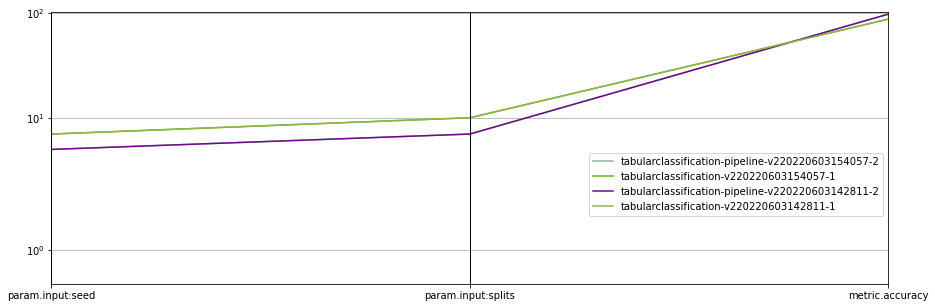

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

### Plot ROC curve and calculate AUC number

In addition to basic metrics, you can extract complex metrics and perform further analysis using the `get_pipeline_df` method.

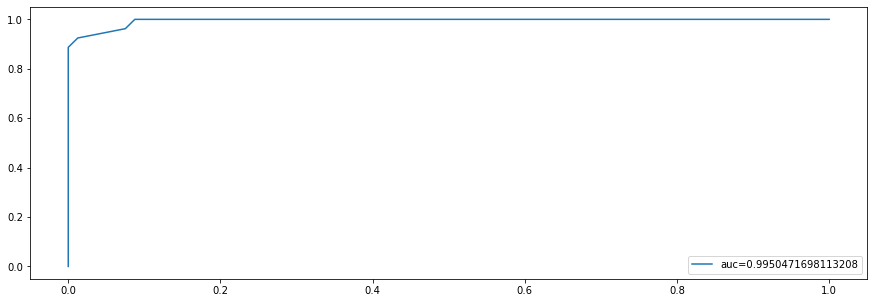

In [85]:
try:
    df = pd.DataFrame(pipeline_df["metric.confidenceMetrics"][0])
    auc = np.trapz(df["recall"], df["falsePositiveRate"])
    plt.plot(df["falsePositiveRate"], df["recall"], label="auc=" + str(auc))
    plt.legend(loc=4)
    plt.show()
except Exception as e:
    print(e)

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial -- *Note:* this is auto-generated and not all resources may be applicable for this tutorial:

- Dataset
- Pipeline
- Model
- Endpoint
- Batch Job
- Custom Job
- Hyperparameter Tuning Job
- Cloud Storage Bucket

In [ ]:
delete_dataset = True
delete_pipeline = True
delete_model = True
delete_endpoint = True
delete_batchjob = True
delete_customjob = True
delete_hptjob = True
delete_bucket = True

try:
    if delete_model and "DISPLAY_NAME" in globals():
        models = aip.Model.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        model = models[0]
        aip.Model.delete(model)
        print("Deleted model:", model)
except Exception as e:
    print(e)

try:
    if delete_endpoint and "DISPLAY_NAME" in globals():
        endpoints = aip.Endpoint.list(
            filter=f"display_name={DISPLAY_NAME}_endpoint", order_by="create_time"
        )
        endpoint = endpoints[0]
        endpoint.undeploy_all()
        aip.Endpoint.delete(endpoint.resource_name)
        print("Deleted endpoint:", endpoint)
except Exception as e:
    print(e)

if delete_dataset and "DISPLAY_NAME" in globals():
    if "tabular" == "tabular":
        try:
            datasets = aip.TabularDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.TabularDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "image":
        try:
            datasets = aip.ImageDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.ImageDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "text":
        try:
            datasets = aip.TextDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.TextDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

    if "tabular" == "video":
        try:
            datasets = aip.VideoDataset.list(
                filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
            )
            dataset = datasets[0]
            aip.VideoDataset.delete(dataset.resource_name)
            print("Deleted dataset:", dataset)
        except Exception as e:
            print(e)

try:
    if delete_pipeline and "DISPLAY_NAME" in globals():
        pipelines = aip.PipelineJob.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        pipeline = pipelines[0]
        aip.PipelineJob.delete(pipeline.resource_name)
        print("Deleted pipeline:", pipeline)
except Exception as e:
    print(e)

if delete_bucket and "BUCKET_NAME" in globals():
    ! gsutil rm -r $BUCKET_NAME